In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn import svm

import shap
from shap import LinearExplainer


# 0. Set preliminaries

In [14]:
# Define the scoring metric with the positive label specified
# Depression = 1
scorer = make_scorer(f1_score, pos_label=1) 

In [15]:
# Set display settings: Turning off scientific notation and getting max column width displays
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)

# 1. Load in the dataset

In [31]:
df = pd.read_csv('../Data/Combined_sets/data_rq1.tsv', header=[0,1], index_col=[0], sep='\t')

In [18]:
columns_list = df.columns.to_list()
# Remove the label column
columns_list = columns_list[:-1]

In [19]:
# Check
print(columns_list)

[('gender', 'male'), ('gender', 'female'), ('age', '19-29'), ('age', '30-39'), ('age', '<=18'), ('age', '>=40'), ('Affect', 'mean_NA'), ('Affect', 'NAV'), ('Affect', 'mean_affect'), ('Affect', 'AV'), ('Affect', 'mean_PA'), ('Affect', 'PAV'), ('Tweet_Count', 'timeline'), ('Tweet_Count', 'sd_words'), ('Tweet_Count', 'min_words'), ('Tweet_Count', 'max_words'), ('Tweet_Count', 'mean_punct'), ('Tweet_Count', 'mean_exclam'), ('Tweet_Count', 'log_punct'), ('Tweet_Count', 'log_exclam'), ('Tweet_Count', 'mentions_p'), ('Emojis', 'mean_emoji'), ('Emojis', 'log_total_emoji'), ('Emojis', 'neg_emoji_p'), ('Emojis', 'pos_emoji_p'), ('CDS_prevalence', 'labeling_mislabeling'), ('CDS_prevalence', 'catastrophising'), ('CDS_prevalence', 'dichotomous_reasoning'), ('CDS_prevalence', 'emotional_reasoning'), ('CDS_prevalence', 'disqualifying_positive'), ('CDS_prevalence', 'magnification_minimisation'), ('CDS_prevalence', 'mental_filtering'), ('CDS_prevalence', 'mindreading'), ('CDS_prevalence', 'fortunetelli

In [20]:
df = df.fillna(0)

# 2. Dataset split and scaling

In [21]:
y = df[("target", "diagnosis")]
X = df.drop([("target", "diagnosis")], axis=1)

In [22]:
# Perform stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)


## 2.2 Scaling

In [23]:
# Initialize the MinMaxScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)

# Transform the validation and test data using the scaler fitted on the training data
X_test = scaler.transform(X_test)


# 3. Support Vector Machine Performance

We used RandomizedSearchCV, so to control for the randomization, we set n_iter to 100 and repeated the model fit 10 times, then taking the best result and hyperparameters from those.

### 1

In [24]:
# Model
svc = svm.SVC(random_state=42, probability=True)

# Tune
skf = StratifiedKFold(n_splits=10, shuffle= True, random_state= 42)

# Grid Search parameters
params = {'kernel': ['linear'],
          'C': [0.1, 1, 10, 100], 
          'gamma': ['scale', 'auto']} 

# Define the scoring metric
scorer = make_scorer(f1_score, pos_label=1)

# Initialize RandomizedSearchCV
random_search_svc = RandomizedSearchCV(estimator= svc, 
                                       param_distributions= params,
                                       cv= skf, 
                                       verbose= True, 
                                       n_jobs= -1, 
                                       n_iter=100, 
                                       scoring=scorer) 

# Fit RandomizedSearchCV to the training data
random_search_svc.fit(X_train, y_train)

# Access the best model
best_svc_model = random_search_svc.best_estimator_

# Print the best parameters and best score
print("Best parameters found: ", random_search_svc.best_params_)
print("Best f1 score found: ", random_search_svc.best_score_)

# Make predictions on the test set
y_test_pred_svc = best_svc_model.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_test_pred_svc)
f1_svm = f1_score(y_test, y_test_pred_svc, pos_label=1)
precision_svm = precision_score(y_test, y_test_pred_svc, pos_label=1)
recall_svm = recall_score(y_test, y_test_pred_svc, pos_label=1)

print("Test accuracy of the SVM model: ", accuracy_svm)
print("Test precision of the SVM model: ", precision_svm)
print("Test recall of the SVM model: ", recall_svm)
print("Test f1 score of the SVM model: ", f1_svm)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x110065bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1041ddbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/ana

Best parameters found:  {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}
Best f1 score found:  0.6249120340808132
Test accuracy of the SVM model:  0.6638888888888889
Test precision of the SVM model:  0.6756756756756757
Test recall of the SVM model:  0.6720430107526881
Test f1 score of the SVM model:  0.6738544474393531


Since the total space of parameters is smaller than N=iter100, we already covered all the options and further repetition is not necessary.

Confusion Matrix

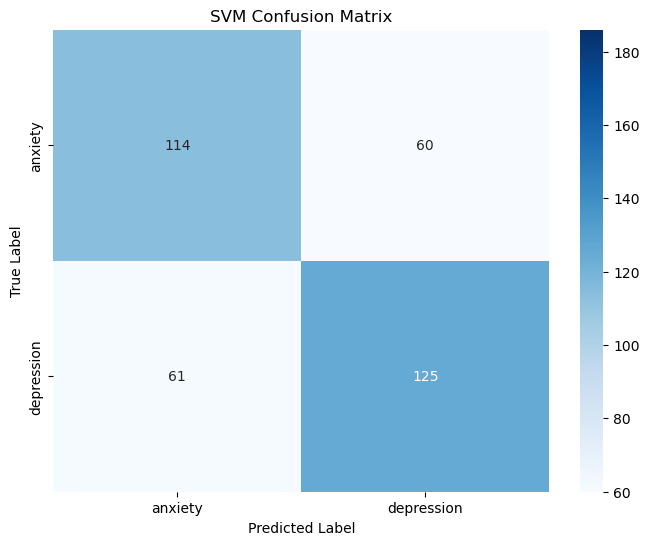

In [27]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_svc, labels=[0, 1])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['anxiety', 'depression'], yticklabels=['anxiety', 'depression'], vmax=186)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.show()

# RQ2: Feature importances

SHAP calculation with LinearExplainer

In [28]:
# explain all the predictions in the test set
linear_explainer_svm = shap.LinearExplainer(best_svc_model, X_train)
shap_values_linear_svm = linear_explainer_svm.shap_values(X_test)

Beeswarm plot for positive depression class, top 20

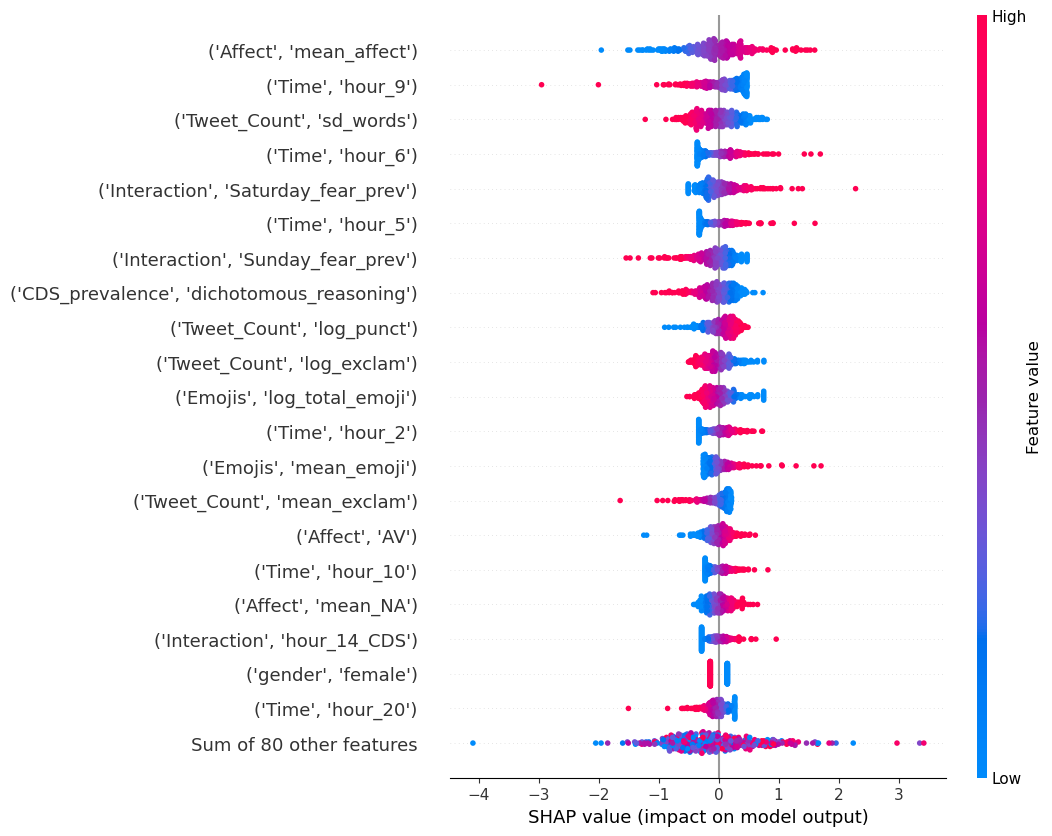

In [29]:
feature_names_svm = columns_list

# Ensure shap_values_rf is a list of arrays for binary classification
# and we select the values for the 'depression' class (assuming it's class 1)
if isinstance(shap_values_linear_svm, list) and len(shap_values_linear_svm) == 2:
    # Assuming 'depression' is the positive class, typically at index 1
    values_for_plot_svm = shap_values_linear_svm[1]
    base_value_svm = shap_values_linear_svm.expected_value[1]
else:
    # If it's not a list, assume it's a single 2D array for binary classification
    values_for_plot_svm = shap_values_linear_svm
    base_value_svm = shap_values_linear_svm

# Create a shap.Explanation object
shap_explanation_svm= shap.Explanation(
    values=values_for_plot_svm,
    base_values=base_value_svm,
    data=X_test, # Convert DataFrame to numpy array if X_test is a DataFrame
    feature_names=feature_names_svm
)

# Now call shap.plots.beeswarm with the Explanation object
plt.figure(figsize=(10, 8))
shap.plots.beeswarm(shap_explanation_svm, max_display=21)

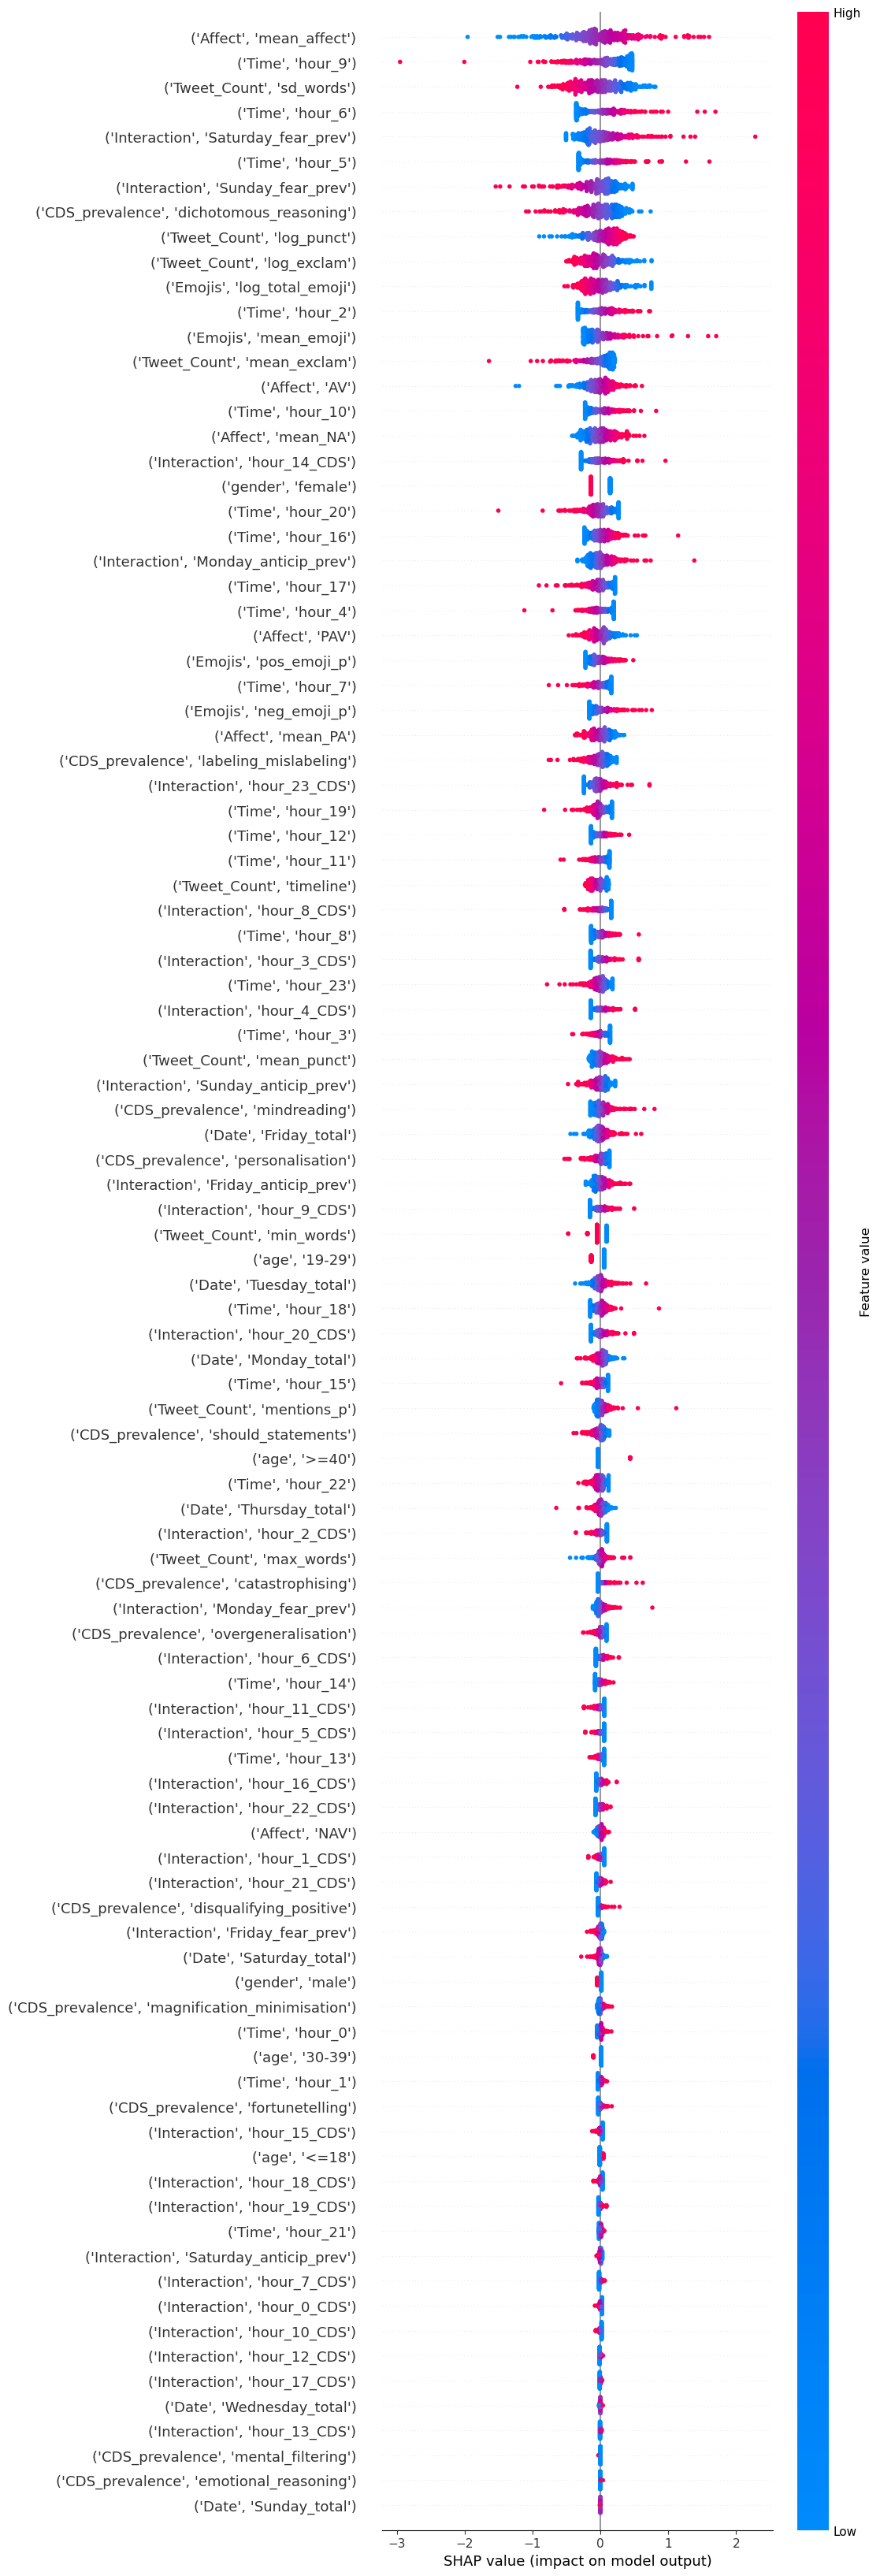

In [30]:
feature_names_svm = columns_list

# Ensure shap_values_rf is a list of arrays for binary classification
# and we select the values for the 'depression' class (assuming it's class 1)
if isinstance(shap_values_linear_svm, list) and len(shap_values_linear_svm) == 2:
    # Assuming 'depression' is the positive class, typically at index 1
    values_for_plot_svm = shap_values_linear_svm[1]
    base_value_svm = shap_values_linear_svm.expected_value[1]
else:
    # If it's not a list, assume it's a single 2D array for binary classification
    values_for_plot_svm = shap_values_linear_svm
    base_value_svm = shap_values_linear_svm

# Create a shap.Explanation object
shap_explanation_svm= shap.Explanation(
    values=values_for_plot_svm,
    base_values=base_value_svm,
    data=X_test, # Convert DataFrame to numpy array if X_test is a DataFrame
    feature_names=feature_names_svm
)

# Now call shap.plots.beeswarm with the Explanation object
plt.figure(figsize=(10, 8))
shap.plots.beeswarm(shap_explanation_svm, max_display=100)